<a href="https://colab.research.google.com/github/itsSuryanshu/3-pre-trained-CNNmodels-LungDisease/blob/main/3_Pretrained_CNN_LungDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Our 3 Pre-Trained Models and Gradio Interface

## The 3 pre-trained that we'll be using are the following:
#### **VGG16:**
> https://keras.io/api/applications/vgg/#vgg16-function

#### **ResNet50V2:**
> https://keras.io/api/applications/resnet/#resnet50v2-function

#### **DesNet121:**
> https://keras.io/api/applications/densenet/#densenet121-function


## Data Preparations

#### These are our imports.

In [1]:
# Imports
import os
import shutil
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
import imghdr
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Lambda, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.densenet import DenseNet121

#### Installs Kaggle and Gradio

In [ ]:
!pip install kaggle gradio

#### Unzips and loads the dataset after downloading it from Kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fatemehmehrparvar/lung-disease
!unzip lung-disease.zip

#### Dataset and file structure manipulation to clean up the folder to be used

In [4]:
root = 'Lung X-Ray Image'
data_folder = os.path.join(root, 'Lung X-Ray Image')

targets = ['Normal', 'Viral Pneumonia']

for target in targets:
  os.makedirs(os.path.join(root, target), exist_ok = True)

for target_dir in targets:
    src_dir = os.path.join(data_folder, target_dir)
    dest_dir = os.path.join(root, target_dir)

    if os.path.exists(src_dir):
        for file_name in os.listdir(src_dir):
            src_file = os.path.join(src_dir, file_name)
            dest_file = os.path.join(dest_dir, file_name)
            shutil.move(src_file, dest_file)

lung_opacity_dir = os.path.join(data_folder, 'Lung Opacity')
if os.path.exists(lung_opacity_dir):
    shutil.rmtree(lung_opacity_dir)

if not os.listdir(data_folder):
    os.rmdir(data_folder)

shutil.rmtree(data_folder)

#### Some images in the dataset may be corrupt so we check for them and if found, they get deleted. This ensures that we will not run into any problems while training our program.

In [5]:
#data directory
data_dir = "Lung X-Ray Image"

#extensions to keep
image_ext = ['jpeg','jpg', 'png']

# Removal of images
for image_class in os.listdir(os.path.join(data_dir)):
  print(f"Checking {image_class}...")
  if image_class == ".DS_Store":
    continue
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      ext = imghdr.what(image_path)
      if ext not in image_ext:
        print("Removing {}".format(image_path))
        os.remove(image_path)
    except Exception as e:
      print("Issues with {}. Might need to be deleted...".format(image_path))

Checking Normal...
Checking Viral Pneumonia...


## **VGG16 Model**

##### We will be starting off with VGG16. A very commonly used pre-trained CNN model that can be fine-tuned for specific tasks without the need of large datasets. It also has only 16 layers with weights as opposed to most models that rely on a large number of hyper-parameters.

#### Augmentations that will be done on the training data.

In [6]:
# training = ImageDataGenerator(
#     rescale = 1./255,
#     rotation_range = 20,
#     zoom_range = 0.2,
#     horizontal_flip = True,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
# )

data_augmentation_vgg = tf.keras.Sequential([
    #tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.Resizing(224, 224)
])

# validation = ImageDataGenerator(
#     rescale = 1./255
# )

#### Partitioning data

In [7]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128

training_set, validation_set = tf.keras.utils.image_dataset_from_directory(
    "Lung X-Ray Image",
    shuffle = True,
    seed = 12345,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
    validation_split = 0.2,
    subset = "both",
    label_mode = "categorical"
)

Found 2350 files belonging to 2 classes.
Using 1880 files for training.
Using 470 files for validation.


In [8]:
# FOR TESTING PURPOSES
for images, labels in training_set.take(1):
    print("Training set batch shape:", images.shape)
for images, labels in validation_set.take(1):
    print("Validation set batch shape:", images.shape)

Training set batch shape: (128, 224, 224, 3)
Validation set batch shape: (128, 224, 224, 3)


#### Functions used to make sure the transformations on both the training batches and validation batches are seamless and won't cause problems during training.

In [9]:
def prepare_training_set(image, label):
  image = data_augmentation_vgg(image)
  image = tf.keras.layers.Rescaling(1./255)(image)
  return image, label

def prepare_validation_set(image, label):
  image = tf.keras.layers.Resizing(224, 224)(image)
  image = tf.keras.layers.Rescaling(1./255)(image)
  return image, label

#### Applying the augmentations to our sets.

In [10]:
# training_set = training_set.map(lambda x, y: (data_augmentation(x, training=True), y))
# validation_set = validation_set.map(lambda x, y: (tf.keras.layers.Rescaling(1./255)(x), y))
training_set = training_set.map(prepare_training_set)
validation_set = validation_set.map(prepare_validation_set)

In [11]:
# FOR TESTING PURPOSES
for images, labels in training_set.take(1):
    print("Training set batch shape:", images.shape)
for images, labels in validation_set.take(1):
    print("Validation set batch shape:", images.shape)

Training set batch shape: (128, 224, 224, 3)
Validation set batch shape: (128, 224, 224, 3)


#### Initializing VGG16 and freezing trainable layers

In [12]:
vgg16 = VGG16(input_shape = IMAGE_SIZE + (3,), weights = 'imagenet', include_top = False)

for layer in vgg16.layers:
  layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Add our own layers on top of the frozen layers and save that as our VGG16 model. By using `vgg_model.summary()` we can see the entire architecture of our model including the frozen layers and our layers.

In [13]:
# Add our layers
x = Flatten()(vgg16.output)
x = Dense(512, activation = 'relu')(x)
predictions = Dense(2, activation = 'softmax')(x)

# Create our model
vgg_model = Model(inputs = vgg16.input, outputs = predictions)

vgg_model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

# Show the structure of the model
vgg_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,561,282 (105.14 MB)

 Trainable params: 12,846,594 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

#### Here we start the training of our model. We also add early stopping callback to end the training if validation loss keeps increasing/doesn't improve for some time.

In [14]:
# Adding early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Training the model
vgg_history = vgg_model.fit(
    training_set,
    validation_data = validation_set,
    epochs = 20,
    callbacks=[early_stopping]
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 123s 6s/step - accuracy: 0.5116 - loss: 4.5362 - val_accuracy: 0.4851 - val_loss: 0.6954
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6651 - loss: 0.6346 - val_accuracy: 0.7468 - val_loss: 0.4557
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8920 - loss: 0.2847 - val_accuracy: 0.8745 - val_loss: 0.2941
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9085 - loss: 0.2376 - val_accuracy: 0.9128 - val_loss: 0.2526
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9381 - loss: 0.2005 - val_accuracy: 0.9234 - val_loss: 0.2234
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9337 - loss: 0.1847 - val_accuracy: 0.9447 - val_loss: 0.1805
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9360 - loss: 0.1661 - val_accuracy: 0.9404 - val_loss: 0.1644
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9465 - loss: 0.1527 - val_accuracy: 0.9489 - val_loss

#### Plot comparing training loss to validation loss for VGG16.

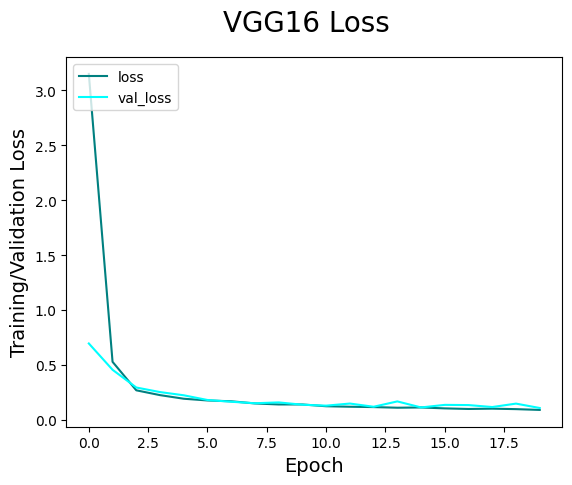

In [15]:
fig = plt.figure()
plt.plot(vgg_history.history["loss"], color="teal", label="loss")
plt.plot(vgg_history.history["val_loss"], color="cyan", label="val_loss")
fig.suptitle("VGG16 Loss", fontsize=20)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training/Validation Loss', fontsize=14)
plt.legend(loc="upper left")
plt.show()

#### Plot comparing the training accuracy to validation accuracy for VGG16.

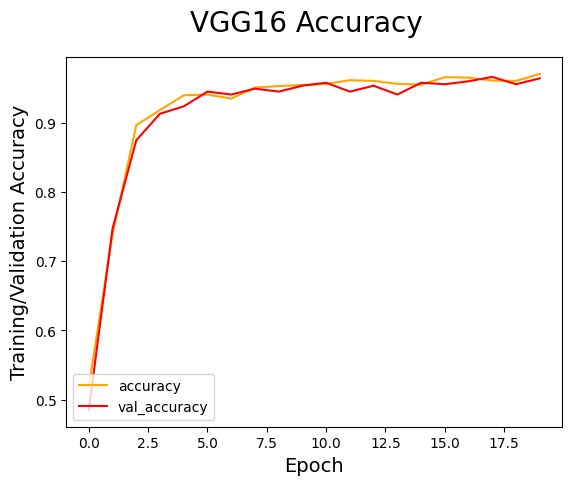

In [16]:
fig = plt.figure()
plt.plot(vgg_history.history["accuracy"], color="orange", label="accuracy")
plt.plot(vgg_history.history["val_accuracy"], color="red", label="val_accuracy")
fig.suptitle("VGG16 Accuracy", fontsize=20)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training/Validation Accuracy', fontsize=14)
plt.legend(loc="lower left")
plt.show()

## VGG16 Testing

In [101]:
img = cv2.imread("lung_xray.jpeg")

In [102]:
resize_img = tf.image.resize(img, (224, 224))
result = vgg_model.predict(np.expand_dims(resize_img/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [103]:
result

array([[0.9568893 , 0.04311072]], dtype=float32)

In [104]:
def classify_result(result):
  predict = np.array(result[0])
  if predict[0] > predict[1]:
    print(f"The X-ray results show it is {round(predict[0]*100, 2)}% Normal")
  else:
    print(f"The X-ray results show it is {round(predict[1]*100, 2)}% Viral Pneumonia")

In [105]:
classify_result(result)

The X-ray results show it is 95.69% Normal


## **ResNet50V2 Model**

##### Second up is the ResNet50V2. Another very commonly used pre-trained CNN model because of it's unique characteristics which include residual learning and utilization of skip connections. This approach enables training of deeper networks, leading to superior performance.

#### Augmentations that will be done on the training data.

In [31]:
data_augmentation_resnet = tf.keras.Sequential([
    #tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.Resizing(224, 224)
])

#### Partitioning data

In [32]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128

training_set, validation_set = tf.keras.utils.image_dataset_from_directory(
    "Lung X-Ray Image",
    shuffle = True,
    seed = 12345,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
    validation_split = 0.2,
    subset = "both",
    label_mode = "categorical"
)

Found 2350 files belonging to 2 classes.
Using 1880 files for training.
Using 470 files for validation.


In [33]:
# FOR TESTING PURPOSES
for images, labels in training_set.take(1):
    print("Training set batch shape:", images.shape)
for images, labels in validation_set.take(1):
    print("Validation set batch shape:", images.shape)

Training set batch shape: (128, 224, 224, 3)
Validation set batch shape: (128, 224, 224, 3)


#### Functions used to make sure the transformations on both the training batches and validation batches are seamless and won't cause problems during training.

In [34]:
def prepare_training_set(image, label):
  image = data_augmentation_resnet(image)
  image = tf.keras.layers.Rescaling(1./255)(image)
  return image, label

def prepare_validation_set(image, label):
  image = tf.keras.layers.Resizing(224, 224)(image)
  image = tf.keras.layers.Rescaling(1./255)(image)
  return image, label

#### Applying the augmentations to our sets.

In [35]:
training_set = training_set.map(prepare_training_set)
validation_set = validation_set.map(prepare_validation_set)

In [36]:
# FOR TESTING PURPOSES
for images, labels in training_set.take(1):
    print("Training set batch shape:", images.shape)
for images, labels in validation_set.take(1):
    print("Validation set batch shape:", images.shape)

Training set batch shape: (128, 224, 224, 3)
Validation set batch shape: (128, 224, 224, 3)


#### Initializing ResNet50V2 and freezing trainable layers

In [37]:
resnet = ResNet50V2(input_shape = IMAGE_SIZE + (3,), weights = 'imagenet', include_top = False)

for layer in resnet.layers:
  layer.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


#### Add our own layers on top of the frozen layers and then save that as our ResNet50V2 model. By using `resnet_model.summary()` we can see the entire architecture of our model including the frozen layers and our layers.

In [38]:
# Add our layers
x = Flatten()(resnet.output)
x = Dense(512, activation = 'relu')(x)
predictions = Dense(2, activation = 'softmax')(x)

# Create our model
resnet_model = Model(inputs = resnet.input, outputs = predictions)

resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

# Show the structure of the model
resnet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 74,946,562 (285.90 MB)

 Trainable params: 51,381,762 (196.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

#### Here we start the training of our model. We also add early stopping callback to end the training if validation loss keeps increasing/doesn't improve for some time.

In [39]:
# Adding early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Training the model
resnet_history = resnet_model.fit(
    training_set,
    validation_data = validation_set,
    epochs = 20,
    callbacks=[early_stopping]
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.6253 - loss: 19.7794 - val_accuracy: 0.8979 - val_loss: 1.3753
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8996 - loss: 1.0955 - val_accuracy: 0.9362 - val_loss: 0.2570
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9517 - loss: 0.1913 - val_accuracy: 0.9234 - val_loss: 0.3486
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9559 - loss: 0.1586 - val_accuracy: 0.9383 - val_loss: 0.2269
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9657 - loss: 0.1075 - val_accuracy: 0.9149 - val_loss: 0.2817
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9599 - loss: 0.1198 - val_accuracy: 0.9532 - val_loss: 0.1259
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9723 - loss: 0.0867 - val_accuracy: 0.9489 - val_loss: 0.1506
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9688 - loss: 0.0811 - val_accuracy: 0.9489 - val_loss

#### Plot comparing training loss to validation loss for ResNet50V2.

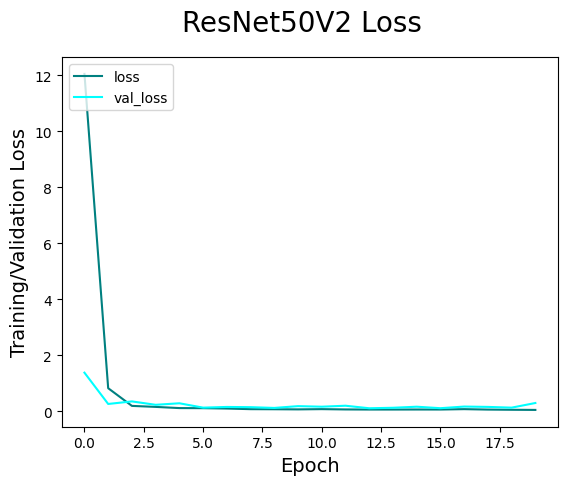

In [40]:
fig = plt.figure()
plt.plot(resnet_history.history["loss"], color="teal", label="loss")
plt.plot(resnet_history.history["val_loss"], color="cyan", label="val_loss")
fig.suptitle("ResNet50V2 Loss", fontsize=20)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training/Validation Loss', fontsize=14)
plt.legend(loc="upper left")
plt.show()

#### Plot comparing the training accuracy to validation accuracy for ResNet50V2.

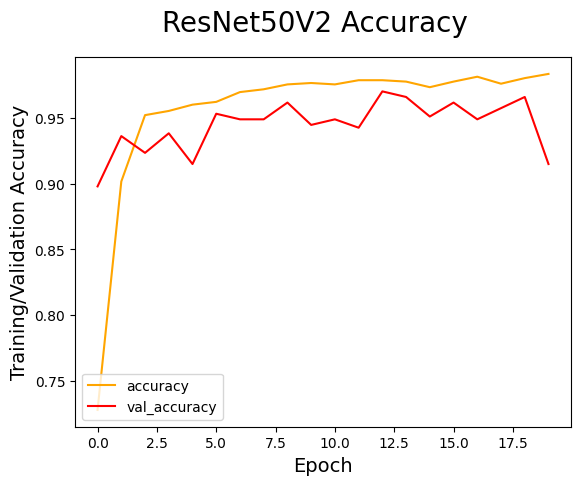

In [41]:
fig = plt.figure()
plt.plot(resnet_history.history["accuracy"], color="orange", label="accuracy")
plt.plot(resnet_history.history["val_accuracy"], color="red", label="val_accuracy")
fig.suptitle("ResNet50V2 Accuracy", fontsize=20)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training/Validation Accuracy', fontsize=14)
plt.legend(loc="lower left")
plt.show()

## ResNet50V2 Testing

In [106]:
img = cv2.imread("lung_xray.jpeg")

In [107]:
resize_img = tf.image.resize(img, (224, 224))
result = resnet_model.predict(np.expand_dims(resize_img/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [108]:
result

array([[9.9999964e-01, 3.7636053e-07]], dtype=float32)

In [109]:
def classify_result(result):
  predict = np.array(result[0])
  if predict[0] > predict[1]:
    print(f"The X-ray results show it is {round(predict[0]*100, 2)}% Normal")
  else:
    print(f"The X-ray results show it is {round(predict[1]*100, 2)}% Viral Pneumonia")

In [110]:
classify_result(result)

The X-ray results show it is 100.0% Normal


## **DenseNet121 Model**

##### The last model we chose is DenseNet121. It's as good as ResNet50 models because both models have similar abilities but what differentiates them is that DenseNet is more parameter-efficient but also takes more memory.

#### Augmentations that will be done on the training data.

In [56]:
data_augmentation_densenet = tf.keras.Sequential([
    #tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.Resizing(224, 224)
])

#### Partitioning data

In [57]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128

training_set, validation_set = tf.keras.utils.image_dataset_from_directory(
    "Lung X-Ray Image",
    shuffle = True,
    seed = 12345,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = "rgb",
    validation_split = 0.2,
    subset = "both",
    label_mode = "categorical"
)

Found 2350 files belonging to 2 classes.
Using 1880 files for training.
Using 470 files for validation.


In [52]:
# FOR TESTING PURPOSES
for images, labels in training_set.take(1):
    print("Training set batch shape:", images.shape)
for images, labels in validation_set.take(1):
    print("Validation set batch shape:", images.shape)

Training set batch shape: (128, 224, 224, 3)
Validation set batch shape: (128, 224, 224, 3)


#### Functions used to make sure the transformations on both the training batches and validation batches are seamless and won't cause problems during training.

In [58]:
def prepare_training_set(image, label):
  image = data_augmentation_densenet(image)
  image = tf.keras.layers.Rescaling(1./255)(image)
  return image, label

def prepare_validation_set(image, label):
  image = tf.keras.layers.Resizing(224, 224)(image)
  image = tf.keras.layers.Rescaling(1./255)(image)
  return image, label

#### Applying the augmentations to our sets.

In [59]:
training_set = training_set.map(prepare_training_set)
validation_set = validation_set.map(prepare_validation_set)

In [64]:
# FOR TESTING PURPOSES
for images, labels in training_set.take(1):
    print("Training set batch shape:", images.shape)
for images, labels in validation_set.take(1):
    print("Validation set batch shape:", images.shape)

Training set batch shape: (128, 224, 224, 3)
Validation set batch shape: (128, 224, 224, 3)


#### Initializing DenseNet121 and freezing trainable layers

In [65]:
densenet = DenseNet121(input_shape = IMAGE_SIZE + (3,), weights = 'imagenet', include_top = False)

for layer in densenet.layers:
  layer.trainable = False

#### Add our own layers on top of the frozen layers and save that as our DenseNet121 model. By using `densenet_model.summary()` we can see the entire architecture of our model including the frozen layers and our layers.

In [67]:
# Add our layers
x = Flatten()(densenet.output)
x = Dense(512, activation = 'relu')(x)
predictions = Dense(2, activation = 'softmax')(x)

# Create our model
densenet_model = Model(inputs = densenet.input, outputs = predictions)

densenet_model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

# Show the structure of the model
densenet_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_6          │ (None, 230, 230, 3)    │              0 │ input_layer_9[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_6[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_7          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_7[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 32,729,154 (124.85 MB)

 Trainable params: 25,691,650 (98.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

#### Here we start the training of our model. We also add early stopping callback to end the training if validation loss keeps increasing/doesn't improve for some time.

In [68]:
# Adding early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Training the model
densenet_history = densenet_model.fit(
    training_set,
    validation_data = validation_set,
    epochs = 20,
    callbacks=[early_stopping]
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.5409 - loss: 26.5991 - val_accuracy: 0.7213 - val_loss: 0.6842
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6016 - loss: 0.6869 - val_accuracy: 0.5021 - val_loss: 0.6221
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6460 - loss: 0.5707 - val_accuracy: 0.9021 - val_loss: 0.4345
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8881 - loss: 0.3943 - val_accuracy: 0.9234 - val_loss: 0.4117
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9266 - loss: 0.3748 - val_accuracy: 0.9255 - val_loss: 0.4014
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9205 - loss: 0.3658 - val_accuracy: 0.9298 - val_loss: 0.3961
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9410 - loss: 0.3467 - val_accuracy: 0.9298 - val_loss: 0.3896
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9416 - loss: 0.3504 - val_accuracy: 0.9298 - val_los

#### Plot comparing training loss to validation loss for DenseNet121.

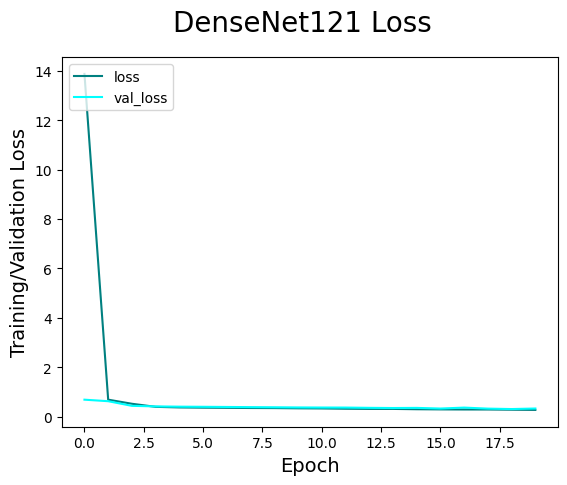

In [69]:
fig = plt.figure()
plt.plot(densenet_history.history["loss"], color="teal", label="loss")
plt.plot(densenet_history.history["val_loss"], color="cyan", label="val_loss")
fig.suptitle("DenseNet121 Loss", fontsize=20)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training/Validation Loss', fontsize=14)
plt.legend(loc="upper left")
plt.show()

#### Plot comparing the training accuracy to validation accuracy for DenseNet121.

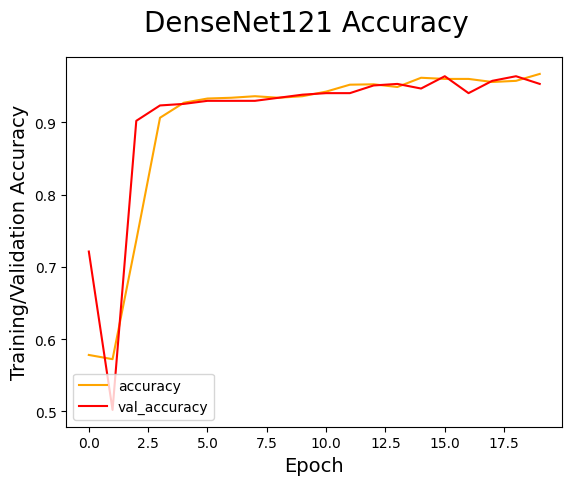

In [70]:
fig = plt.figure()
plt.plot(densenet_history.history["accuracy"], color="orange", label="accuracy")
plt.plot(densenet_history.history["val_accuracy"], color="red", label="val_accuracy")
fig.suptitle("DenseNet121 Accuracy", fontsize=20)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Training/Validation Accuracy', fontsize=14)
plt.legend(loc="lower left")
plt.show()

## DenseNet121 Testing

In [111]:
img = cv2.imread("lung_xray.jpeg")

In [112]:
resize_img = tf.image.resize(img, (224, 224))
result = densenet_model.predict(np.expand_dims(resize_img/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [113]:
result

array([[0.9648659 , 0.03513411]], dtype=float32)

In [114]:
def classify_result(result):
  predict = np.array(result[0])
  if predict[0] > predict[1]:
    print(f"The X-ray results show it is {round(predict[0]*100, 2)}% Normal")
  else:
    print(f"The X-ray results show it is {round(predict[1]*100, 2)}% Viral Pneumonia")

In [115]:
classify_result(result)

The X-ray results show it is 96.49% Normal
